#### Maps of surface precipitation in prognostic runs for baseline physics, RF, and NN ensemble

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import os
import cftime
import intake
import fsspec
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
import json
import copy

import fv3viz as viz
from vcm.catalog import catalog
from vcm.fv3.metadata import standardize_fv3_diagnostics

def weighted_average(array, weights, axis=None):
    return np.nansum(array * weights, axis=axis) / np.nansum(weights, axis=axis)


MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

SECONDS_PER_DAY = 86400


In [2]:
def get_prog_run_precip_bias(
        diags_path,
        verif_precip,
        var="total_precipitation_rate", 
        start_time=cftime.DatetimeJulian(2016, 8, 11, 0, 0, 0, 0)
):
    ds = intake.open_zarr(diags_path).to_dask().sortby("time")
    verif_precip = verif_precip.sortby("time")
    prog_times = ds.sel(time=slice(start_time, None)).time.values
    verif_times = verif_precip.sortby("time")
    verif_times = verif_times.sel(time=slice(start_time, None)).time.values
    overlap_times = sorted(list(set(verif_times).intersection(prog_times)))
    
    da_verif = verif_precip.sortby("time")[var].sel(time=overlap_times)
    ds = ds.sortby("time").sel(time=overlap_times)
    ds["total_precip_to_surface_time_mean_bias"] = (ds["total_precipitation_rate"] - da_verif) * SECONDS_PER_DAY 
    return ds[["total_precip_to_surface_time_mean_bias"]].mean("time").load()

def concat_ics(ic_paths, start_datetimes, ic_coord, verif_physics):
    ic_data = []
    for path, start_datetime in zip(ic_paths, start_datetimes):
        ds = get_prog_run_precip_bias(
                os.path.join(path, "diags.zarr"),
                verif_physics,
                start_time=start_datetime
        )
        
        ic_data.append(ds)
    
    return xr.concat(ic_data, dim=pd.Index(ic_coord, name="ic"))

def insert_subplot(ax, ds, var, label, subplot_label, fontsize=18):
    mappable_var = viz.mappable_var(ds.merge(grid), var, **MAPPABLE_VAR_KWARGS)
    rmse = np.sqrt(weighted_average(ds[var]**2, area))
    bias = weighted_average(ds[var], area)
    fig, _, _, cbar, _ = viz.plot_cube(
        mappable_var,
        vmax=vmax,
        cbar_label="Precipitation bias [mm/day]",
        ax= ax,
        rasterized=True
    )
    cbar.ax.get_yaxis().get_label().set_fontsize(14)
    title = f"{label} \n RMSE={rmse:3.2f} mm/day"
    ax.set_title(title, fontsize=18)
    ax.text(-0.075, 1.2, subplot_label, va='top', fontsize=fontsize, transform=ax.transAxes)


In [3]:
   
grid = catalog["grid/c48"].read()
area = grid["area"]

land_sea_mask = catalog["landseamask/c48"].read()["land_sea_mask"]

verif_physics = standardize_fv3_diagnostics(catalog['40day_c48_gfsphysics_15min_may2020'].to_dask())
verif_physics["total_precipitation_rate"] = verif_physics["PRATEsfc"]

In [4]:
ics = ["20160805.000000", "20160805.000000", "20160805.000000", "20160805.000000"]

baseline_ics = [f"gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-201608{start_day}-start-rad-step-1800s" for start_day in ["05", "13", "21", "29"]]
nn_ics = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/{ic}" for ic in ics]
rf_ics = ["gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/{ic}" for ic in ics]
control_nudging_tq_rf_ics = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/{ic}" for ic in ics]


In [14]:
nn_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/nn-ensemble-model/initial_conditions_runs/20160805.000000/diags.zarr",
        verif_physics
)
rf_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/initial_conditions_runs/20160805.000000/diags.zarr",
        verif_physics
)
baseline_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805-start-rad-step-1800s/diags.zarr",
        verif_physics
)
baseline_fast_sat_adj_precip_bias = get_prog_run_precip_bias(
        "gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805.000000-start-rad-step-1800s-fast-sat-adj/diags.zarr",
        verif_physics
)

#### Bar plot for domain averages of precip bias and RMSE

In [18]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []

#labels = ["Baseline physics", "Random forest", "Neural network ensemble" ]
labels = ["Base no-ML", "Base-fast-sat-adj no-ML", "$TqR$-RF", "$TqR$-NN"]

#datasets = [diags_baseline, diags_rf, diags_nn, ]
datasets = [baseline_precip_bias, baseline_fast_sat_adj_precip_bias, rf_precip_bias, nn_precip_bias]
for domain in ["global", "land", "ocean"]:
    for label, ds in zip(labels, datasets):
        if domain == "global":
            area_masked = area
            da = ds[var]
        elif domain == "land":
            area_masked = area.where(land_sea_mask==1)
            da = ds[var].where(land_sea_mask==1)
        elif domain == "ocean":
            area_masked = area.where(land_sea_mask==0)
            da = ds[var].where(land_sea_mask==0)            
        bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).values.item()
        rmse = np.sqrt( 
            (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
        ).values.item()        
        domain_avg_biases.append([domain, label, rmse, bias])
        
biases = pd.DataFrame(domain_avg_biases, columns=["domain", "dataset", "RMSE", "bias"])


In [19]:
biases

,domain,dataset,RMSE,bias
0,global,Base no-ML,3.655571,-0.048362
1,global,Base-fast-sat-adj no-ML,3.061411,-0.051390
2,global,$TqR$-RF,2.538595,-0.076063
3,global,$TqR$-NN,2.556271,-0.235811
4,land,Base no-ML,4.598237,1.093459
5,land,Base-fast-sat-adj no-ML,2.557607,-0.328261
6,land,$TqR$-RF,1.984518,0.115097
7,land,$TqR$-NN,2.008285,0.036406
8,ocean,Base no-ML,3.288070,-0.526417
9,ocean,Base-fast-sat-adj no-ML,3.331508,0.081779


### Save table of IC ensemble mean and std for ablation study

In [21]:
ics = ["20160805.000000", "20160813.000000", "20160821.000000", "20160829.000000"]
start_datetimes = [cftime.DatetimeJulian(2016, 8, day, 0, 0, 0, 0) for day in [11, 19, 27,]] + [cftime.DatetimeJulian(2016, 9, 4, 0, 0, 0, 0)]

baseline_no_ML_paths = [f"gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-201608{start_day}-start-rad-step-1800s" for start_day in ["05", "13", "21", "29"]]
baseline_fast_sat_adj_no_ML_paths = ["gs://vcm-ml-experiments/2021-04-13/baseline-physics-run-20160805.000000-start-rad-step-1800s-fast-sat-adj"]
temperature_moisture_RF_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-dq1-dq2-rf/initial_conditions_runs/{ic}" for ic in ics] 
temperature_moisture_winds_RF_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/{ic}" for ic in ics]
temperature_moisture_winds_prescribed_sfc_RF_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/{ic}" for ic in ics]
temperature_moisture_winds_prescribed_sfc_NN_ensemble_paths = [f"gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/{ic}" for ic in ics]

temperature_moisture_prescribed_sfc_RF_paths = [f"gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/rf/initial_conditions_runs/{ic}" for ic in ics]
temperature_moisture_prescribed_sfc_NN_ensemble_paths = [f"gs://vcm-ml-experiments/2021-06-21-nudge-to-c3072-dq1-dq2-only/nn-ensemble-model/initial_conditions_runs/{ic}" for ic in ics]



In [45]:
baseline_fast_sat_adj_no_ML = concat_ics(
    baseline_fast_sat_adj_no_ML_paths,
    [cftime.DatetimeJulian(2016, 8, 11, 0, 0, 0, 0)],
    ["20160805.000000"],
    verif_physics
)

In [8]:
args = [start_datetimes, ics, verif_physics]

baseline_no_ML = concat_ics(baseline_no_ML_paths, *args)
temperature_moisture_RF = concat_ics(temperature_moisture_RF_paths, *args)
temperature_moisture_winds_RF = concat_ics(temperature_moisture_winds_RF_paths, *args)
temperature_moisture_winds_prescribed_sfc_RF = concat_ics(temperature_moisture_winds_prescribed_sfc_RF_paths, *args)
temperature_moisture_winds_prescribed_sfc_NN_ensemble = concat_ics(temperature_moisture_winds_prescribed_sfc_NN_ensemble_paths, *args)
temperature_moisture_prescribed_sfc_RF  = concat_ics(temperature_moisture_prescribed_sfc_RF_paths, *args)
temperature_moisture_prescribed_sfc_NN_ensemble = concat_ics(temperature_moisture_prescribed_sfc_NN_ensemble_paths, *args)

In [46]:
var= "total_precip_to_surface_time_mean_bias"

domain_avg_biases = []

labels = [
    "base-no-ML",
    "base-fast-sat-adj-no-ML",
    "Tq-RF",
    "Tquv-RF",
    "TquvR-RF",
    "TquvR-NN",
    "TqR-RF",
    "TqR-NN",
]

datasets = [
    baseline_no_ML,
    baseline_fast_sat_adj_no_ML,
    temperature_moisture_RF, 
    temperature_moisture_winds_RF,
    temperature_moisture_winds_prescribed_sfc_RF, 
    temperature_moisture_winds_prescribed_sfc_NN_ensemble,
    temperature_moisture_prescribed_sfc_RF ,
    temperature_moisture_prescribed_sfc_NN_ensemble
]
for domain in ["global", "land", "ocean"]:
    for label, ds_ in zip(labels, datasets):
        for ic in ics:
            if ic in ds_.ic:
                ds = copy.copy(ds_).sel(ic=ic)
                if domain == "global":
                    area_masked = area
                    da = ds[var]
                elif domain == "land":
                    area_masked = area.where(land_sea_mask==1)
                    da = ds[var].where(land_sea_mask==1)
                elif domain == "ocean":
                    area_masked = area.where(land_sea_mask==0)
                    da = ds[var].where(land_sea_mask==0)     
                bias = ((da * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)).values.item()
                rmse = np.sqrt( 
                    (da**2 * area_masked).sum(skipna=True, dim=["tile", "x", "y"]) / area_masked.sum(skipna=True)
                ).values.item()        
                domain_avg_biases.append([ic, domain, label, rmse, bias,])

df = pd.DataFrame(domain_avg_biases, columns=["IC", "domain", "dataset", "RMSE", "bias"])

In [47]:
ablation_land_sfc_precip_bias = {
    "variable": "land_surface_precipitation_bias",
    "units": "mm/day"
}
for experiment in labels:
    row = df.loc[df["domain"]=="land"].loc[df["IC"]=="20160805.000000"].loc[df["dataset"]==experiment]
    ablation_land_sfc_precip_bias[experiment] = row["bias"].item()

    
ablation_global_sfc_precip_rmse = {
    "variable": "global_surface_precipitation_rmse",
    "units": "mm/day"
}
for experiment in labels:
    row = df.loc[df["domain"]=="global"].loc[df["IC"]=="20160805.000000"].loc[df["dataset"]==experiment]
    ablation_global_sfc_precip_rmse[experiment] = row["RMSE"].item()

with open("tables/ablation_sfc_precip.json", "w") as f:
    json.dump([ablation_land_sfc_precip_bias, ablation_global_sfc_precip_rmse], f, indent=4)

In [48]:
print(df.to_string())

                 IC  domain                  dataset      RMSE      bias
0   20160805.000000  global               base-no-ML  3.655571 -0.048362
1   20160813.000000  global               base-no-ML  3.699861  0.007019
2   20160821.000000  global               base-no-ML  3.892562 -0.053059
3   20160829.000000  global               base-no-ML  4.303806 -0.120951
4   20160805.000000  global  base-fast-sat-adj-no-ML  3.061411 -0.051390
5   20160805.000000  global                    Tq-RF  2.659678  0.090469
6   20160813.000000  global                    Tq-RF  2.657589  0.137751
7   20160821.000000  global                    Tq-RF  3.025634  0.135408
8   20160829.000000  global                    Tq-RF  3.612060  0.038248
9   20160805.000000  global                  Tquv-RF  2.722468  0.145335
10  20160813.000000  global                  Tquv-RF  2.699513  0.164000
11  20160821.000000  global                  Tquv-RF  2.978697  0.118811
12  20160829.000000  global                  Tquv-R

#### Single composite figure

In [39]:
# from cartopy import crs as ccrs
# sb.reset_orig()
    
# var = "total_precip_to_surface_time_mean_bias"
# vmax = 10
# fig_size = (12,5)

# labels = ["$TqR$-NN", "$TqR$-RF", "Base no-ML"]
# datasets = [nn_precip_bias, rf_precip_bias, baseline_precip_bias]

# # manually define b/c seaborn screws up the default setting
# default_colormap = ['#006BA4',
#  '#FF800E',
#  '#ABABAB',
#  '#595959',
#  '#5F9ED1',
#  '#C85200',
#  '#898989',
#  '#A2C8EC',
#  '#FFBC79',
#  '#CFCFCF']
# colors = [default_colormap[3], default_colormap[0], default_colormap[5]]


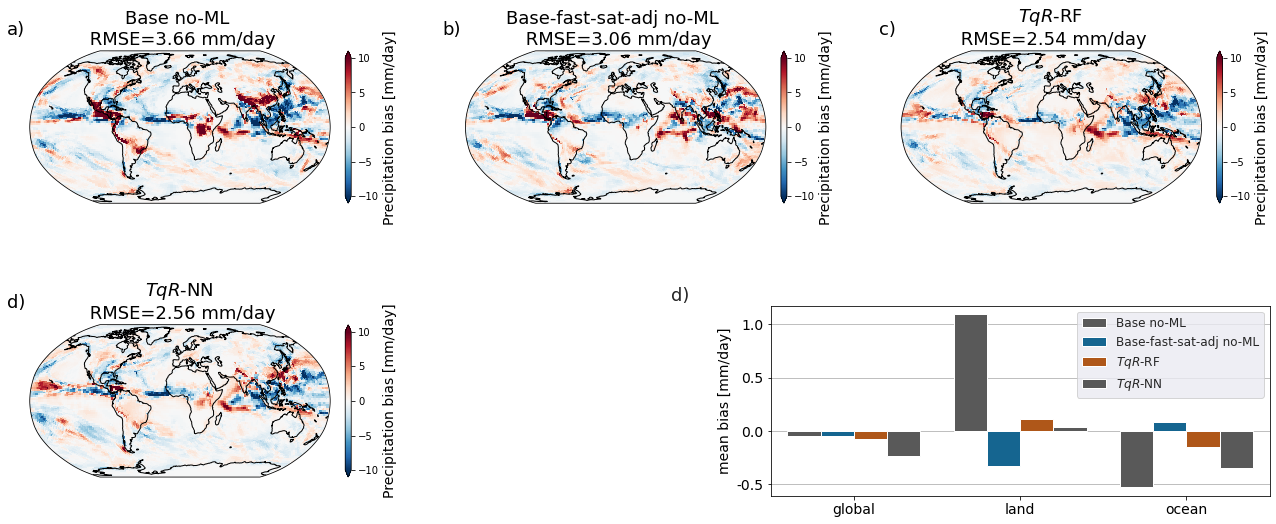

In [44]:
sb.reset_orig()

fig, axes = plt.subplots(2, 3, subplot_kw={"projection":ccrs.Robinson()}, figsize=(21, 8))

cbar = insert_subplot(axes[0][0], baseline_precip_bias, "total_precip_to_surface_time_mean_bias", "Base no-ML", "a)")
cbar = insert_subplot(axes[0][1], baseline_fast_sat_adj_precip_bias, "total_precip_to_surface_time_mean_bias", "Base-fast-sat-adj no-ML", "b)")
insert_subplot(axes[0][2], rf_precip_bias, "total_precip_to_surface_time_mean_bias", "$TqR$-RF", "c)")
insert_subplot(axes[1][0], nn_precip_bias, "total_precip_to_surface_time_mean_bias", "$TqR$-NN", "d)")


# d) bar plot
axes[1][1].set_axis_off()

left = 0.615
bottom = 0.1
width = 0.33
height = 0.33
ax = fig.add_axes([left, bottom, width, height])

#sb.set_theme(style='darkgrid')
#sb.despine(bottom = False, left = False)
sb.set(font_scale = 1.1)
b = sb.barplot(
    x="domain", 
    y="bias", 
    hue="dataset", 
    data=biases,
    palette=colors,
    ax = ax,
    rasterized=True
)
b.set_yticklabels([-1.0, -0.5, 0.0, 0.5, 1.0, 1.5], fontsize=14)
b.set_xticklabels(['global', 'land', 'ocean'], fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("mean bias [mm/day]", fontsize=14)
ax.set_axisbelow(True)
ax.grid(axis="y")
ax.legend(loc="upper right")
ax.text(-0.2, 1.1, "d)", va='top', fontsize=18, transform=ax.transAxes)

fig.subplots_adjust(hspace=0.7, wspace=0.45)
plt.savefig("figures/Figure_11_PrecBiasMaps.png", bbox_inches = "tight")